<a href="https://colab.research.google.com/github/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/05-text-generation/text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Text Generation

One of the most uncanny features of transformer-based language models is
their ability to generate text that is almost indistinguishable from text written
by humans.


As we’ve seen, for task-specific
heads like sequence or token classification, generating predictions is fairly
straightforward; the model produces some logits and we either take the
maximum value to get the predicted class, or apply a softmax function to
obtain the predicted probabilities per class.

By contrast, converting the
model’s probabilistic output to text requires a decoding method, which
introduces a few challenges that are unique to text generation:

* The decoding is done iteratively and thus involves significantly
more compute than simply passing inputs once through the forward
pass of a model.

* The quality and diversity of the generated text depend on the choice
of decoding method and associated hyperparameters.

To understand how this decoding process works, let’s start by examining
how GPT-2 is pretrained and subsequently applied to generate text.

Like other autoregressive or causal language models, GPT-2 is pretrained
to estimate the probability $P(y|x)$ of a sequence of tokens $y=y_1,y_2,...,y_t$ occurring in the text, given some initial prompt or context sequence $x=x_1,x_2,...,x_k$.

Since it is impractical to acquire enough training data to
estimate $P(y|x)$ directly, it is common to use the chain rule of probability to factorize it as a product of conditional probabilities:

$$ P(y_1,y_2,...,y_t|x) = \prod_{t=1}^N P(y_t|y_{<t}, x)$$

It is from
these conditional probabilities that we pick up the intuition that
autoregressive language modeling amounts to predicting each word given the
preceding words in a sentence; this is exactly what the probability on the
righthand side of the preceding equation describes.

Notice that this
pretraining objective is quite different from BERT’s, which utilizes both past
and future contexts to predict a masked token.

<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/05-text-generation/images/text-generation.png?raw=1" id="text-generation"/> 


As shown, we start with a prompt like "Transformers are the" and use the model to
predict the next token. Once we have determined the next token, we append it
to the prompt and then use the new input sequence to generate another token.
We do this until we have reached a special end-of-sequence token or a
predefined maximum length.

>Since the output sequence is conditioned on the choice of input prompt, this type of text generation is often called conditional text generation.

At the heart of this process lies a decoding method that determines which
token is selected at each timestep.

Since the language model head produces a logit $z_{t,i}$ per token in the vocabulary at each step, we can get the probability
distribution over the next possible token $w_i$ by taking the softmax:

$$ P(y_t=w_i|y_{<t},x) = softmax(z_{t,i}) $$

The goal of most decoding methods is to search for the most likely overall
sequence by picking a $\hat y$ such that:

$$ \hat y = argmax P(y|x) $$

Finding $\hat y$ directly would involve evaluating every possible sequence with the language model. Since there does not exist an algorithm that can do this in a reasonable amount of time, we rely on approximations instead.

##Setup

In [ ]:
!pip -q install transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import cross_entropy

from transformers import AutoTokenizer, AutoModelForCausalLM

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

##Greedy Search Decoding

The simplest decoding method to get discrete tokens from a model’s
continuous output is to greedily select the token with the highest probability
at each timestep:

$$ \hat y_t = argmax P(y_t|y_{<t}, x) $$

To see how greedy search works, let’s start by loading the 1.5-billion parameter version of `GPT-2` with a language modeling head:

In [ ]:
# model_name = "gpt2-xl"
model_name = "gpt2"  # due RAM issue, loading smaller model

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Now let’s generate some text! 

Although Transformers provides a
`generate()` function for autoregressive models like `GPT-2`, we’ll implement
this decoding method ourselves to see what goes on under the hood.

We’ll use `Transformers are the` as the input prompt and run the decoding for eight timesteps.

At each timestep, we pick out the model’s logits for the last token
in the prompt and wrap them with a softmax to get a probability distribution.
We then pick the next token with the highest probability, add it to the input
sequence, and run the process again.

In [5]:
input_text = "Transformers are the"
input_ids = tokenizer(input_text, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
  for _ in range(n_steps):
    iteration = dict()
    iteration["Input"] = tokenizer.decode(input_ids[0])
    output = model(input_ids=input_ids)

    # Select logits of the first batch and the last token and apply softmax
    next_token_logits = output.logits[0, -1, :]
    next_token_probs = torch.softmax(next_token_logits, dim=-1)
    sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)

    # Store tokens with highest probabilities
    for choice_idx in range(choices_per_step):
      token_id = sorted_ids[choice_idx]
      token_prob = next_token_probs[token_id].cpu().numpy()
      token_choice = (f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)")
      iteration[f"Choice {choice_idx + 1}"] = token_choice
    
    # Append predicted next token to input
    input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
    iterations.append(iteration)

pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (9.76%),same (2.94%),only (2.87%),best (2.38%),first (1.77%)
1,Transformers are the most,common (22.90%),powerful (6.88%),important (6.32%),popular (3.95%),commonly (2.14%)
2,Transformers are the most common,type (15.06%),types (3.31%),form (1.91%),way (1.89%),and (1.49%)
3,Transformers are the most common type,of (83.13%),in (3.16%),. (1.92%),", (1.63%)",for (0.88%)
4,Transformers are the most common type of,particle (1.55%),object (1.02%),light (0.71%),energy (0.67%),objects (0.66%)
5,Transformers are the most common type of particle,. (14.26%),in (11.57%),that (10.18%),", (9.57%)",accelerator (5.81%)
6,Transformers are the most common type of parti...,They (17.48%),\n (15.19%),The (7.06%),These (3.09%),In (3.07%)
7,Transformers are the most common type of parti...,are (38.77%),have (8.14%),can (7.99%),'re (5.04%),consist (1.57%)


We can also see the other possible continuations
at each step, which shows the iterative nature of text generation.

Unlike other
tasks such as sequence classification where a single forward pass suffices to
generate the predictions, with text generation we need to decode the output
tokens one at a time.

Implementing greedy search wasn’t too hard, but we’ll want to use the builtin
`generate()` function from Transformers to explore more sophisticated
decoding methods.

In [6]:
input_ids = tokenizer(input_text, return_tensors="pt")["input_ids"].to(device)
# specify the max_new_tokens for the number of newly generated tokens
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [7]:
print(tokenizer.decode(output[0]))

Transformers are the most common type of particle. They are


Now let’s try something a bit more interesting.

In [8]:
max_length = 128
input_txt = """
In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""

input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [9]:
print(tokenizer.decode(output_greedy[0]))


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Berkeley, and the University of California, Santa Cruz, found that the unicorns were able to communicate with each other through their tongues.


"This is a very interesting finding," said lead author Dr. David J. Karp, a professor of linguistics at the University of California, Berkeley. "It's a very interesting finding that we can


We can see one of the main drawbacks with greedy search decoding: it
tends to produce repetitive output sequences, which is certainly undesirable
in a news article. 

This is a common problem with greedy search algorithms,
which can fail to give you the optimal solution; in the context of decoding,
they can miss word sequences whose overall probability is higher just
because high-probability words happen to be preceded by low-probability
ones.

Although greedy search decoding is rarely used for text generation tasks that require diversity, it can be useful for producing short sequences like arithmetic where a deterministic and factually correct output is preferred.

For these tasks, you can condition `GPT-2` by providing a few line-separated examples in the format `5 + 8 => 13 \n 7 +
2 => 9 \n 1 + 0 =>` as the input prompt.

In [10]:
max_length = 128
input_arithmatic = """5 + 8 => 13 \n 7 + 2 => 9 \n 1 + 0 =>"""

input_ids = tokenizer(input_arithmatic, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [11]:
print(tokenizer.decode(output_greedy[0]))

5 + 8 => 13 
 7 + 2 => 9 
 1 + 0 => 10 

1 + 1 => 11 

1 + 2 => 12 

1 + 3 => 13 

1 + 4 => 14 

1 + 5 => 15 

1 + 6 => 16 

1 + 7 => 17 

1 + 8 => 18 

1 + 9 => 19 

1 + 10 => 20 

1 + 11 => 21 

1 + 12 => 22 

1 + 13 => 23 

1 +


In [12]:
max_length = 128
input_arithmatic = """1 + 2 => 3 \n 2 + 3 => 5 \n 3 + 4 =>"""

input_ids = tokenizer(input_arithmatic, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [13]:
print(tokenizer.decode(output_greedy[0]))

1 + 2 => 3 
 2 + 3 => 5 
 3 + 4 => 6 

4 + 5 => 7 

5 + 6 => 8 

6 + 7 => 9 

7 + 8 => 10 

8 + 9 => 11 

9 + 10 => 12 

10 + 11 => 13 

11 + 12 => 14 

12 + 13 => 15 

13 + 14 => 16 

14 + 15 => 17 

15 + 16 => 18 

16 + 17 => 19 

17 +


Fortunately, we can do better—let’s examine a popular method known as
beam search decoding.

##Beam Search Decoding

Instead of decoding the token with the highest probability at each step, beam
search keeps track of the top-b most probable next tokens, where b is
referred to as the number of beams or partial hypotheses.

The next set of
beams are chosen by considering all possible next-token extensions of the
existing set and selecting the b most likely extensions. 

The process is
repeated until we reach the maximum length or an EOS token, and the most likely sequence is selected by ranking the b beams according to their log
probabilities.

Why do we score the sequences using log probabilities instead of the
probabilities themselves?

That calculating the overall probability of a
sequence $P(y_1, y_2, ..., y_t|x)$ involves calculating a product of conditional
probabilities $P(y_t|y_{<t}, x)$ is one reason.

Since each conditional probability
is typically a small number in the range `[0, 1]`, taking their product can lead
to an overall probability that can easily underflow. 

This means that the
computer can no longer precisely represent the result of the calculation.

For
example, suppose we have a sequence of `t = 1024` tokens and generously
assume that the probability for each token is 0.5. 

The overall probability for
this sequence is an extremely small number:

In [14]:
0.5 ** 1024

5.562684646268003e-309

which leads to numerical instability as we run into underflow. We can avoid
this by calculating a related term, the log probability.

If we apply the
logarithm to the joint and conditional probabilities, then with the help of the
product rule for logarithms we get:

$$ log P(y_1, y_2,...,y_t|x) = \sum_{t=1}^N log P(y_t|y_{<t},x) $$

In other words, the product of probabilities we saw earlier becomes a sum of
log probabilities, which is much less likely to run into numerical
instabilities.

For example, calculating the log probability of the same
example as before gives:

In [15]:
sum([np.log(0.5)] * 1024)

-709.7827128933695

This is a number we can easily deal with, and this approach still works for
much smaller numbers. 

Since we only want to compare relative
probabilities, we can do this directly with log probabilities.

Since Transformers models return the unnormalized logits for
the next token given the input tokens, we first need to normalize the logits to
create a probability distribution over the whole vocabulary for each token in
the sequence. 

We then need to select only the token probabilities that were
present in the sequence.

In [16]:
def log_probs_from_logits(logits, labels):
  logp = F.log_softmax(logits, dim=-1)
  logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
  return logp_label

This gives us the log probability for a single token, so to get the total log
probability of a sequence we just need to sum the log probabilities for each
token:

In [17]:
def sequence_log_probs(model, labels, input_len=0):
  with torch.no_grad():
    output = model(labels)
    log_probs = log_probs_from_logits(output.logits[:, :-1, :], labels[:, 1:])
    seq_log_prob = torch.sum(log_probs[:, input_len:])
  return seq_log_prob.cpu().numpy()

We can also see that it is important to align
the logits and the labels; since the model predicts the next token,we do not
get a logit for the first label, and we don’t need the last logit because we
don’t have a ground truth token for it.

Let’s use these functions to first calculate the sequence log probability of the
greedy decoder.

In [18]:
max_length = 128
input_txt = """
In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""

input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [19]:
logp = sequence_log_probs(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Berkeley, and the University of California, Santa Cruz, found that the unicorns were able to communicate with each other through their tongues.


"This is a very interesting finding," said lead author Dr. David J. Karp, a professor of linguistics at the University of California, Berkeley. "It's a very interesting finding that we can

log-prob: -99.74


Now let’s compare this to a sequence that is generated with beam search.

To
activate beam search with the `generate()` function we just need to specify
the number of beams with the num_beams parameter. 

The more beams we
choose, the better the result potentially gets; however, the generation process
becomes much slower since we generate parallel sequences for each beam:

In [20]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, do_sample=False)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [21]:
logp = sequence_log_probs(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, San Diego, and the University of California, Santa Cruz, found that the unicorns were able to communicate with each other in a way that was similar to that of human speech.


"The unicorns were able to communicate with each other in a way that was similar to that of human speech," said study co-author Dr. David J.

log-prob: -74.68


We can see that we get a better log probability (higher is better) with beam
search than we did with simple greedy decoding.

However, we can see that
beam search also suffers from repetitive text. 

One way to address this is to
impose an n-gram penalty with the `no_repeat_ngram_size` parameter that
tracks which n-grams have been seen and sets the next token probability to
zero if it would produce a previously seen n-gram:

In [22]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, no_repeat_ngram_size=2, do_sample=False)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [23]:
logp = sequence_log_probs(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, San Diego, and the National Science Foundation (NSF) in Boulder, Colorado, were able to translate the words of the unicorn into English, which they then translated into Spanish.

"This is the first time that we have translated the word 'unicorn' from English to Spanish," said study co-lead author Dr. David J. K

log-prob: -102.56


We’ve managed to stop the repetitions, and we can see
that despite producing a lower score, the text remains coherent.

**Beam search with n-gram penalty is a good way to find a trade-off between focusing on high-probability tokens (with beam search) while reducing repetitions (with n-gram penalty), and it’s commonly used in applications such as summarization or machine translation where factual correctness is important.**

**When factual correctness is less important than the diversity of generated
output, for instance in open-domain chitchat or story generation, another
alternative to reduce repetitions while improving diversity is to use
sampling.**

##Sampling Methods

The simplest sampling method is to randomly sample from the probability
distribution of the model’s outputs over the full vocabulary at each timestep:

$$  P(y_t|y_{<t}, x) = softmax(z_{t, i}) = \frac {exp(z_{t,i})} {\sum_{j=1}^{|V|} exp(z_{t,i})} $$

We can easily control
the diversity of the output by adding a temperature parameter $T$ that rescales the logits before taking the softmax:

$$  P(y_t|y_{<t}, x) = \frac {exp(z_{t,i} / T)} {\sum_{j=1}^{|V|} exp(z_{t,i}/T)} $$

By tuning $T$ we can control the shape of the probability distribution.

When $T<1$, the distribution becomes peaked around the origin and the rare
tokens are suppressed.

On the other hand, when $T>1$, the distribution
flattens out and each token becomes equally likely.

Let's plot the effect of temperature
on token probabilities.



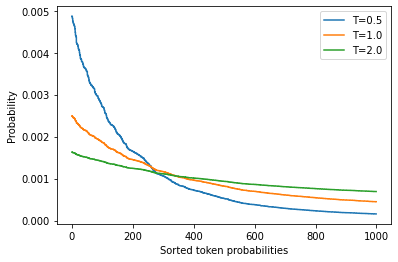

In [24]:
def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

To see how we can use temperature to influence the generated text, let’s
sample with $T=2$ by setting the temperature parameter in the
`generate()` function.

In [25]:
torch.manual_seed(42);

In [26]:
output_temp = model.generate(input_ids, max_length=max_length, temperature=2.0, top_k=0, do_sample=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [27]:
print(tokenizer.decode(output_temp[0]))


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


Tickets to take 21 protagonist receive 1700 cutsonstes ModelsZeetta flashbacks Unless she laugh at Erdogan although Kashun Naj Tribe Auct Turner Dor Grizz dexkg mereumblr ebook 131 class inequariansiamond disse *clubument existential whilst spear mad majority beongs coaching Archdemonana Everest Stimsetspres gladakThings does Guillard Ty physician Hidden Kimville sleeves Zel Oz at affopy temporou MD Thermal radi


We can clearly see that a high temperature has produced mostly gibberish; by
accentuating the rare tokens, we’ve caused the model to create strange
grammar and quite a few made-up words!

Let’s see what happens if we cool
down the temperature:

In [28]:
output_temp = model.generate(input_ids, max_length=max_length, temperature=0.5, top_k=0, do_sample=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [29]:
print(tokenizer.decode(output_temp[0]))


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers from the University of California, Davis, and the University of Washington, in Washington, D.C., used DNA from more than 1,000 individuals, including more than 100,000 in the Andes Mountains, to identify the unicorns.

Anthropologist David Allen, of the University of California, Davis, said: "It is not uncommon to see a herd of unic


This is significantly more coherent, and even includes a quote from yet
another university being credited with the discovery!

**The main lesson we can draw from temperature is that it allows us to control the quality of the samples, but there’s always a trade-off between coherence (low temperature) and diversity (high temperature) that one has to tune to the use case at hand.**

Another way to adjust the trade-off between coherence and diversity is to
truncate the distribution of the vocabulary. This allows us to adjust the
diversity freely with the temperature, but in a more limited range that
excludes words that would be too strange in the context (i.e., low-probability
words). 

There are two main ways to do this: 

* `top-k` sampling
* nucleus (or `top-p`) sampling

##Top-k and Nucleus Sampling

`Top-k` and nucleus(top-p) sampling are two popular alternatives or extensions to using temperature. In both cases, the basic idea is to restrict the number of possible tokens we can sample from at each timestep.

Let’s first visualize the cumulative probability distribution of the model’s outputs at $T = 1$.

In [30]:
with torch.no_grad():
  output = model(input_ids=input_ids)
  next_token_logits = output.logits[:, -1, :]
  probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

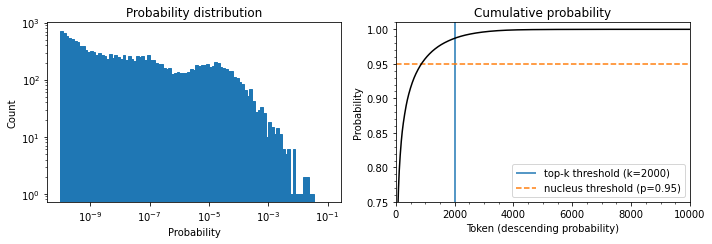

In [31]:
# Probability distribution of next token prediction.
# Probability distribution of next token prediction (left) and cumulative distribution of descending token probabilities
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

The idea behind top-k sampling is to avoid the low-probability choices by only sampling
from the k tokens with the highest probability. This puts a fixed cut on the long
tail of the distribution and ensures that we only sample from likely choices.

So, `top-k` sampling is equivalent to defining a vertical line and sampling
from the tokens on the left. 

Again, the `generate()` function provides an easy
method to achieve this with the `top_k` argument:

In [32]:
torch.manual_seed(42);

output_topk = model.generate(input_ids, max_length=max_length, top_k=50, do_sample=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [33]:
print(tokenizer.decode(output_topk[0]))


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


That's right. According to researchers from the Royal Society of Edinburgh and the University of Edinburgh, the unicorn is capable of speaking some 20 languages including Spanish, Icelandic, the Danish language, Arabic, French, and Chinese, according to the Spanish studies.


"The unicorn has been shown to be able to produce large-scale language development and speak large numbers of English words, both orally and through


This is arguably the most human-looking text we’ve generated so far. 

But how do we choose $k$?

The value of $k$ is chosen manually and is the same for each choice in the
sequence, independent of the actual output distribution. We can find a good value for $k$ by looking at some text quality metrics—but that fixed cutoff might not be very satisfactory.

An alternative is to use a dynamic cutoff. With nucleus or `top-p` sampling, instead of choosing a fixed cutoff value, we set a condition of when to cut off. This condition is when a certain probability mass in the selection is reached.

Let’s say we set that value to `95%`. We then order all tokens in descending order by probability and add one
token after another from the top of the list until the sum of the probabilities of the
selected tokens is `95%`.

So, the value for $p$ defines a horizontal line on the cumulative sum of probabilities plot, and we sample only from tokens
below the line. 

Depending on the output distribution, this could be just one (very
likely) token or a hundred (more equally likely) tokens. 

At this point, you are probably
not surprised that the `generate()` function also provides an argument to activate `top-p` sampling.

In [34]:
torch.manual_seed(42);

output_topp = model.generate(input_ids, max_length=max_length, top_p=0.90, do_sample=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [35]:
print(tokenizer.decode(output_topp[0]))


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The scientists found that the unicorns, called "suspect unicorns," are common in South America and the Andes as well as the Himalayan mountains of Nepal and Tibet. In fact, the unicorns are called "suspect unicorns." The researchers also found that the unicorns speak a language that's like a little Mandarin or Russian.


This discovery could be a major


Top-p sampling has also produced a coherent story.

You can even combine the two
sampling approaches to get the best of both worlds. Setting `top_k=50` and `top_p=0.9` corresponds to the rule of choosing tokens with a probability mass of `90%`, from a pool of at most 50 tokens.

In [36]:
torch.manual_seed(42);

output_top_kp = model.generate(input_ids, max_length=max_length, top_k=50, top_p=0.90, do_sample=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [37]:
print(tokenizer.decode(output_top_kp[0]))


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The scientists found that the unicorns, called "suspect unicorns," are common in South America and the Andes as well as the Himalayan mountains of Nepal and Tibet. In fact, the unicorns are called "suspect unicorns." The researchers also found that the unicorns speak a language that's like a little Mandarin or Russian.


This discovery could be a major


We can also apply beam search when we use sampling. Instead of
selecting the next batch of candidate tokens greedily, we can sample
them and build up the beams in the same way.

In [39]:
torch.manual_seed(42);

output_top_kp_beam = model.generate(input_ids, max_length=max_length, top_k=50, top_p=0.90, num_beams=5, do_sample=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [40]:
print(tokenizer.decode(output_top_kp_beam[0]))


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers say the unicorns, which live in the Andes Mountains, are native to the Andes.

The researchers believe that the unicorns, which live in the Andes Mountains, are native to the Andes.


The researchers say the unicorns, which live in the Andes Mountains, are native to the Andes.


The researchers say the unicorns,


We again see the word repeatation.

In [41]:
torch.manual_seed(42);

output_top_kp_beam_ngram = model.generate(input_ids, max_length=max_length, top_k=50, top_p=0.90, num_beams=5, no_repeat_ngram_size=2, do_sample=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [42]:
print(tokenizer.decode(output_top_kp_beam_ngram[0]))


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, led by Dr. Jean-François Lévesque, from the Université de Montréal in France, found that they were able to speak the language fluently and correctly.

"This is not the first time that we have found a language that is completely foreign to humans," said Lecomte, who was not involved with the study. "But


Now, the repeating words are eliminated.

##Conclusion

Unfortunately, there is no universally “best” decoding method. Which approach is best will depend on the nature of the task you are generating text for.

If you want
your model to perform a precise task like arithmetic or providing an answer to a specific
question, then you should lower the temperature or use deterministic methods
like greedy search in combination with beam search to guarantee getting the most
likely answer.


If you want the model to generate longer texts and even be a bit creative,
then you should switch to sampling methods and increase the temperature or
use a mix of `top-k` and nucleus sampling.

In addition, a good decoding strategy that transforms
the model’s output probabilities into discrete tokens can improve the text quality.


Finding the best decoding strategy requires some experimentation and a subjective
evaluation of the generated texts.